1. data missing dan data duplicate
2. data skewness
3. data imbalanced di isFraud
4. log transform
5. label encoding
6. drop kolom gk penting
7. train model (dengan stratified split)
8. evaluasi model

dataset : https://www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset/code

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("fraud detection") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

df = spark.read.csv("C:/Users/Abhinaya/hello world/praktikum-ai-modul-2-2025/fraud_detection_classification/AIML Dataset.csv", header=True, inferSchema=True)

df.show(20)
df.printSchema()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [2]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [3]:
from pyspark.sql.functions import count

# Hitung total baris
total_rows = df.count()

# Hitung baris unik (distinct)
distinct_rows = df.distinct().count()

# Hitung duplikat
duplicate_rows = total_rows - distinct_rows
print(f"Total duplicate rows: {duplicate_rows}")

Total duplicate rows: 0


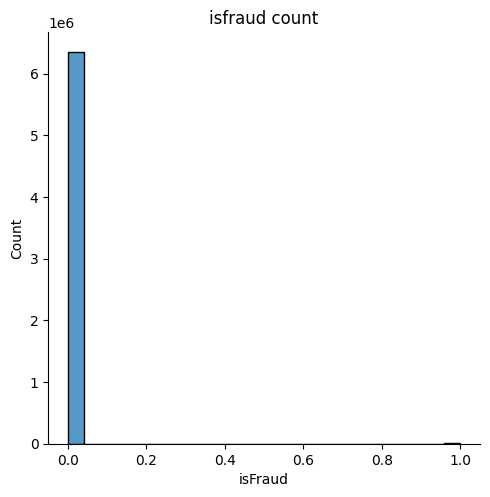

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pandas_df = pd.read_csv('C:/Users/Abhinaya/hello world/praktikum-ai-modul-2-2025/fraud_detection_classification/AIML Dataset.csv')

sns.displot(data=pandas_df['isFraud'])
plt.title('isfraud count')
plt.show()

In [5]:
from pyspark.sql.functions import count, round

total_count = df.count()

fraud_pct = (
    df.groupBy("isFraud")
      .count()
      .withColumn("percentage", round((col("count") / total_count) * 100, 2))
)

fraud_pct.show()

+-------+-------+----------+
|isFraud|  count|percentage|
+-------+-------+----------+
|      1|   8213|      0.13|
|      0|6354407|     99.87|
+-------+-------+----------+



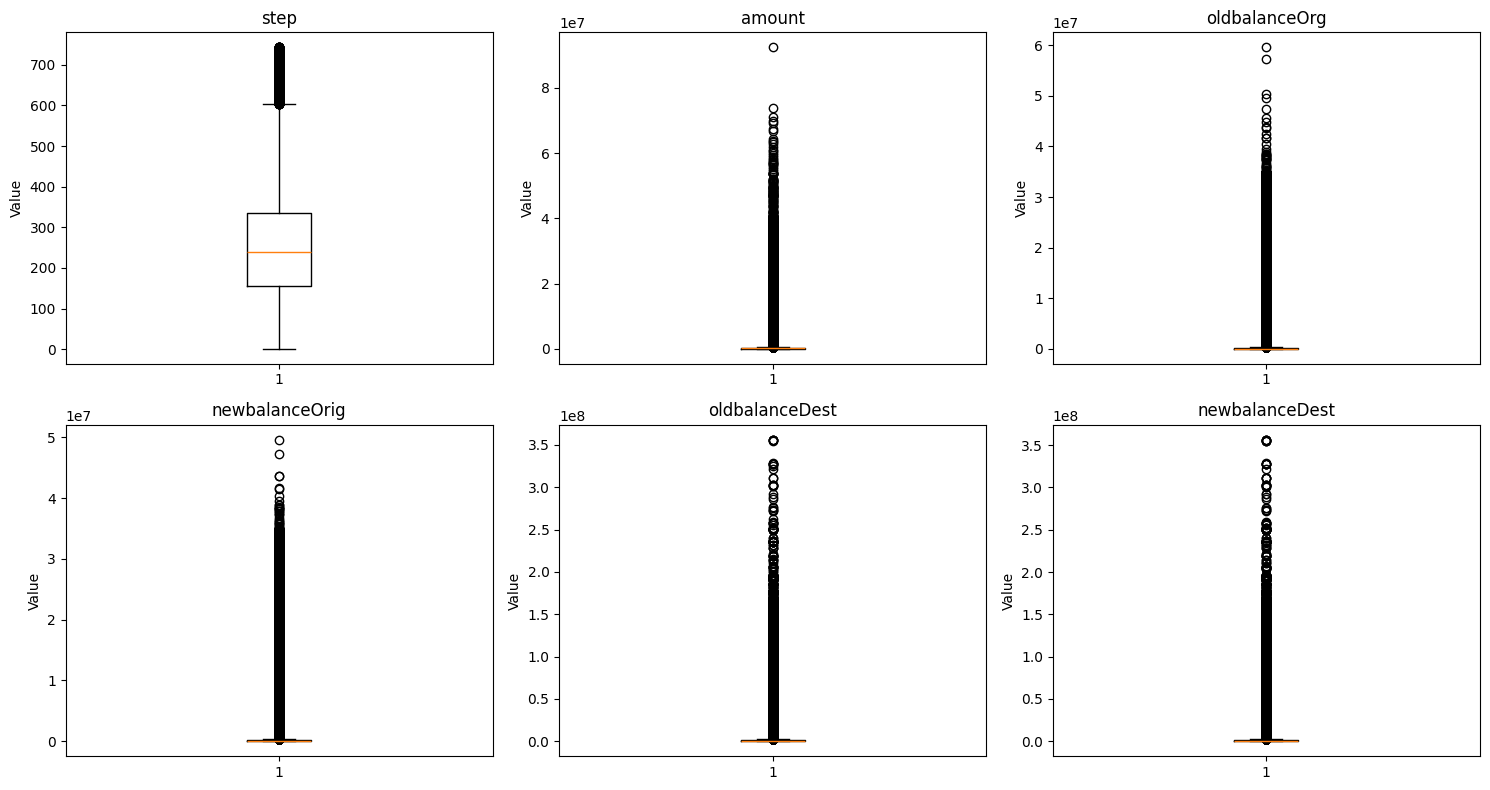

In [6]:
pdf_iqr = pandas_df.drop(['nameOrig', 'type', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis=1)

import math
import matplotlib.pyplot as plt

cols = pdf_iqr.columns
n = len(cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(5 * ncols, 4 * nrows))

axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.boxplot(pdf_iqr[col].dropna())
    ax.set_title(col)
    ax.set_ylabel('Value')

for ax in axes[n:]:
    ax.axis('off')

fig.tight_layout()
plt.show()

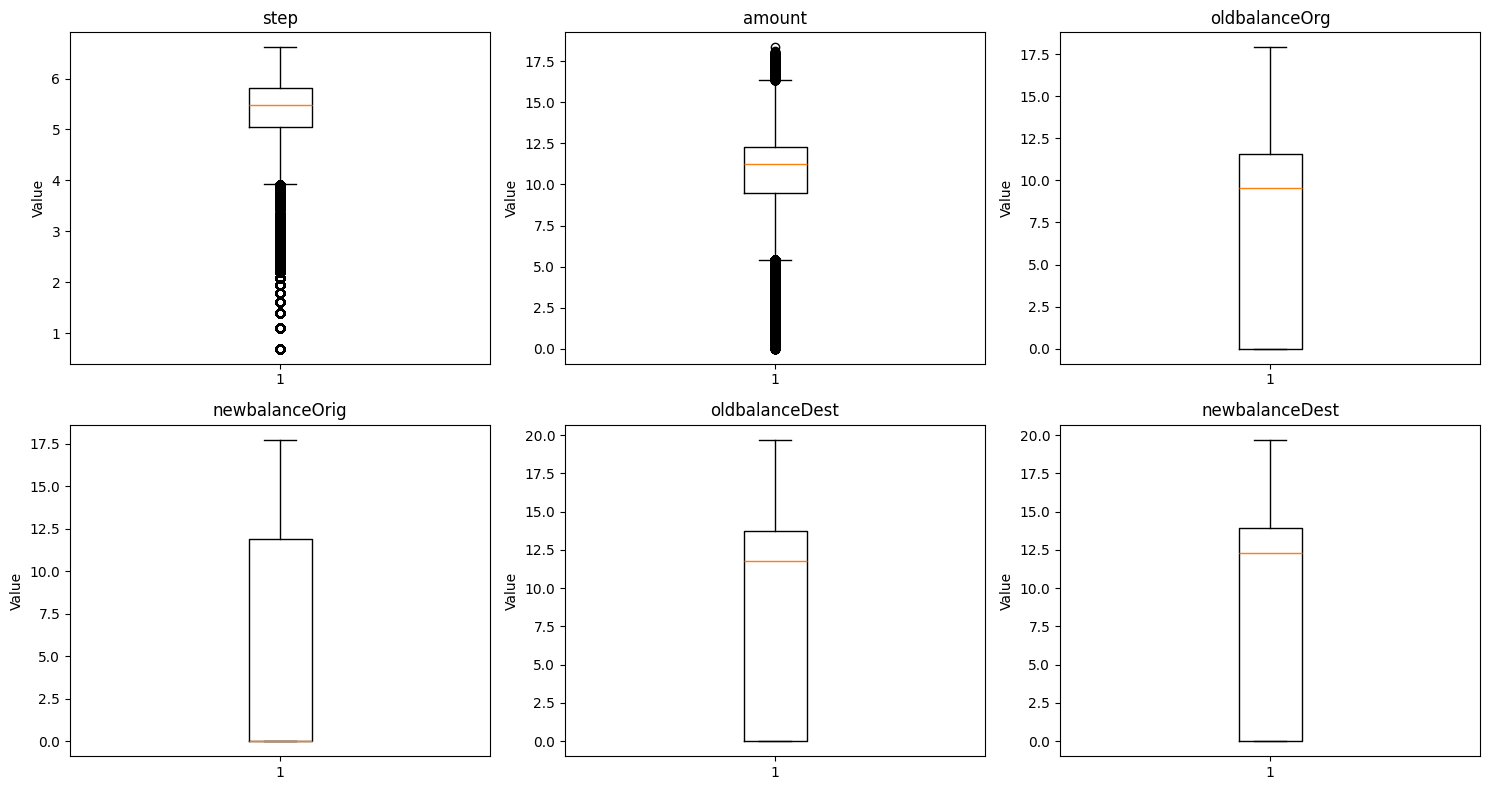

In [7]:
import numpy as np

#  log1p (log(1+x)) so zeros don’t break
pdf_log = pdf_iqr.apply(np.log1p)

cols = pdf_log.columns
n = len(cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(5 * ncols, 4 * nrows))

axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.boxplot(pdf_log[col].dropna())
    ax.set_title(col)
    ax.set_ylabel('Value')

# turn off any unused subplots
for ax in axes[n:]:
    ax.axis('off')

fig.tight_layout()
plt.show()

In [8]:
from pyspark.sql.functions import log1p, col

num_col = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

for col_name in num_col:
    df = df.withColumn(col_name, log1p(col(col_name)))

In [9]:
from pyspark.ml.feature import StringIndexer

# Buat StringIndexer
indexer = StringIndexer(inputCol="type", outputCol="type_index")

# Fit dan transform
df = indexer.fit(df).transform(df)

# Lihat hasil
df.show(20)

+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+-------+--------------+----------+
|              step|    type|            amount|   nameOrig|     oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|isFraud|isFlaggedFraud|type_index|
+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+-------+--------------+----------+
|0.6931471805599453| PAYMENT| 9.194276028581655|C1231006815| 12.04435927383651|11.984785869341627|M1979787155|               0.0|               0.0|      0|             0|       1.0|
|0.6931471805599453| PAYMENT| 7.531166454857185|C1666544295| 9.964112174352563| 9.872291991535475|M2044282225|               0.0|               0.0|      0|             0|       1.0|
|0.6931471805599453|TRANSFER| 5.204006687076795|C1305486145| 5.204006687076795|      

In [10]:
# Pisahkan berdasarkan label
df_fraud = df.filter(df["isFraud"] == 1)
df_nonfraud = df.filter(df["isFraud"] == 0)

# Lakukan split pada masing-masing kelas
fraud_train, fraud_test = df_fraud.randomSplit([0.8, 0.2], seed=42)
nonfraud_train, nonfraud_test = df_nonfraud.randomSplit([0.8, 0.2], seed=42)

# Gabungkan kembali hasil split
train_df = fraud_train.union(nonfraud_train)
test_df = fraud_test.union(nonfraud_test)

train_df = train_df.drop('nameOrig', 'type', 'nameDest', 'isFlaggedFraud')
test_df = test_df.drop('nameOrig', 'type', 'nameDest', 'isFlaggedFraud')

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier

# Gabungkan semua kolom fitur
feature_cols = [col for col in train_df.columns if col != "isFraud"]

# Ubah ke format vektor
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_prepared = assembler.transform(train_df).select('features', 'isFraud')
test_prepared = assembler.transform(test_df).select('features', 'isFraud')

In [12]:
gbt = GBTClassifier(labelCol='isFraud', featuresCol='features', maxIter=50)
model = gbt.fit(train_prepared)

In [13]:
predictions = model.transform(test_prepared)

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np

ALPHA = 0.75

def weighted_error_rate(y_true, y_pred, alpha=ALPHA):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return (alpha * fnr) + ((1 - alpha) * fpr)

pdf = predictions.select('isFraud', 'prediction').toPandas()

tn, fp, fn, tp = confusion_matrix(pdf['isFraud'], pdf['prediction']).ravel()

evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)
w_err = weighted_error_rate(pdf['isFraud'], pdf['prediction'])
print(f"Weighted Error Rate (α={ALPHA}): {w_err:.4f}")

AUC: 0.9946809696640703
Weighted Error Rate (α=0.75): 0.2036


In [15]:
total = tn + fp + fn + tp

print(f"True Negative (TN): {tn} ({tn / total * 100:.2f}%)")
print(f"False Positive (FP): {fp} ({fp / total * 100:.2f}%)")
print(f"False Negative (FN): {fn} ({fn / total * 100:.2f}%)")
print(f"True Positive (TP): {tp} ({tp / total * 100:.2f}%)")

True Negative (TN): 1270907 (99.87%)
False Positive (FP): 34 (0.00%)
False Negative (FN): 429 (0.03%)
True Positive (TP): 1151 (0.09%)


In [16]:
accuracy = (tp + tn)/total
print("Accuracy:", accuracy)

Accuracy: 0.9996361553168868


In [17]:
# Pisahkan berdasarkan label
df_fraud = df.filter(df["isFraud"] == 1)
df_nonfraud = df.filter(df["isFraud"] == 0)

# Lakukan split pada masing-masing kelas
fraud_train, fraud_test = df_fraud.randomSplit([0.8, 0.2], seed=42)
nonfraud_train, nonfraud_test = df_nonfraud.randomSplit([0.8, 0.2], seed=42)

fraud_train_oversampled = fraud_train.sample(withReplacement=True, fraction=5.0, seed=42)

# === Gabungkan data training
train_df = fraud_train_oversampled.union(nonfraud_train)

# === Gabungkan data testing
test_df = fraud_test.union(nonfraud_test)

# === Hapus kolom yang tidak digunakan
cols_to_drop = ['nameOrig', 'type', 'nameDest', 'isFlaggedFraud']
train_df = train_df.drop(*cols_to_drop)
test_df = test_df.drop(*cols_to_drop)


In [18]:
features = [col for col in train_df.columns if col != 'isFraud']
assembler = VectorAssembler(inputCols=features, outputCol='features')

GBTClassifier

In [19]:
from pyspark.ml import Pipeline

gbt = GBTClassifier(labelCol='isFraud', featuresCol='features', maxIter=50, maxDepth=5)

pipeline = Pipeline(stages=[assembler, gbt])

model = pipeline.fit(train_df)

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

predictions = model.transform(test_df)

# === Adjust threshold: lebih sensitif (misalnya > 0.3)
adjust_threshold = udf(lambda prob: float(prob[1] > 0.5), DoubleType())
predictions = predictions.withColumn("adjusted_prediction", adjust_threshold(predictions["probability"]))

In [21]:
ALPHA = 0.75

def weighted_error_rate(y_true, y_pred, alpha=ALPHA):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return (alpha * fnr) + ((1 - alpha) * fpr)

pdf = predictions.select('isFraud', 'prediction').toPandas()

tn, fp, fn, tp = confusion_matrix(pdf['isFraud'], pdf['prediction']).ravel()

evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)
w_err = weighted_error_rate(pdf['isFraud'], pdf['prediction'])
print(f"Weighted Error Rate (α={ALPHA}): {w_err:.4f}")

AUC: 0.9965996210582097
Weighted Error Rate (α=0.75): 0.1871


In [22]:
total = tn + fp + fn + tp

print(f"True Negative (TN): {tn} ({tn / total * 100:.2f}%)")
print(f"False Positive (FP): {fp} ({fp / total * 100:.2f}%)")
print(f"False Negative (FN): {fn} ({fn / total * 100:.2f}%)")
print(f"True Positive (TP): {tp} ({tp / total * 100:.2f}%)")

True Negative (TN): 1270752 (99.86%)
False Positive (FP): 189 (0.01%)
False Negative (FN): 394 (0.03%)
True Positive (TP): 1186 (0.09%)


In [23]:
accuracy = (tp + tn)/total
print("Accuracy:", accuracy)

Accuracy: 0.9995418543191036


RandomForest

In [27]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[assembler, rf])
rf_model = pipeline.fit(train_df)

In [28]:
predictions = rf_model.transform(test_df)

In [29]:
ALPHA = 0.75

def weighted_error_rate(y_true, y_pred, alpha=ALPHA):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return (alpha * fnr) + ((1 - alpha) * fpr)

pdf = predictions.select('isFraud', 'prediction').toPandas()

tn, fp, fn, tp = confusion_matrix(pdf['isFraud'], pdf['prediction']).ravel()

evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)
w_err = weighted_error_rate(pdf['isFraud'], pdf['prediction'])
print(f"Weighted Error Rate (α={ALPHA}): {w_err:.4f}")

AUC: 0.9879672249523002
Weighted Error Rate (α=0.75): 0.2711


In [30]:
total = tn + fp + fn + tp

print(f"True Negative (TN): {tn} ({tn / total * 100:.2f}%)")
print(f"False Positive (FP): {fp} ({fp / total * 100:.2f}%)")
print(f"False Negative (FN): {fn} ({fn / total * 100:.2f}%)")
print(f"True Positive (TP): {tp} ({tp / total * 100:.2f}%)")

True Negative (TN): 1270902 (99.87%)
False Positive (FP): 39 (0.00%)
False Negative (FN): 571 (0.04%)
True Positive (TP): 1009 (0.08%)


In [31]:
accuracy = (tp + tn)/total
print("Accuracy:", accuracy)

Accuracy: 0.9995206365946023


In [33]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="isFraud", featuresCol="features")
pipeline = Pipeline(stages=[assembler, lr])
lr_model = pipeline.fit(train_df)

In [34]:
predictions = lr_model.transform(test_df)

In [35]:
ALPHA = 0.75

def weighted_error_rate(y_true, y_pred, alpha=ALPHA):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return (alpha * fnr) + ((1 - alpha) * fpr)

pdf = predictions.select('isFraud', 'prediction').toPandas()

tn, fp, fn, tp = confusion_matrix(pdf['isFraud'], pdf['prediction']).ravel()

evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)
w_err = weighted_error_rate(pdf['isFraud'], pdf['prediction'])
print(f"Weighted Error Rate (α={ALPHA}): {w_err:.4f}")

AUC: 0.984251436085845
Weighted Error Rate (α=0.75): 0.2948


In [36]:
total = tn + fp + fn + tp

print(f"True Negative (TN): {tn} ({tn / total * 100:.2f}%)")
print(f"False Positive (FP): {fp} ({fp / total * 100:.2f}%)")
print(f"False Negative (FN): {fn} ({fn / total * 100:.2f}%)")
print(f"True Positive (TP): {tp} ({tp / total * 100:.2f}%)")

True Negative (TN): 1270808 (99.87%)
False Positive (FP): 133 (0.01%)
False Negative (FN): 621 (0.05%)
True Positive (TP): 959 (0.08%)


In [37]:
accuracy = (tp + tn)/total
print("Accuracy:", accuracy)

Accuracy: 0.9994074753972626


In [38]:
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.memory', '4g'),
 ('spark.app.name', 'fraud detection'),
 ('spark.executor.id', 'driver'

In [39]:
spark.stop()